# LQR, iLQR, and MPC

## A simple LQR problem
Suppose we want to penalize difference from a target state and the magnitude of the input. We can write this as a linear-quadratic-regulator (LQR) problem as follows,

\begin{align}
c(x, u) &= \frac{1}{2} \|x - x^\star\|_2^2 + \frac{1}{2} \rho \|u\|_2^2 \\
        &= \frac{1}{2} x^\top x - x^\top x^\star + \frac{1}{2} \rho u^\top u  + \mathrm{const} \\
        &= \frac{1}{2} 
        \begin{bmatrix} x & u \end{bmatrix} 
        \begin{bmatrix} Q & 0 \\ 0 & R \end{bmatrix} 
        \begin{bmatrix} x \\ u \end{bmatrix}
        + 
        \begin{bmatrix} x & u \end{bmatrix}
        \begin{bmatrix} q \\ r \end{bmatrix} 
        + \mathrm{const.}
\end{align}
where $Q = I$, $q = -x^\star$, and $R = \rho I$. (Implicitly, $r = 0$ and $M=0$)


In [1]:
import collections

from jax import lax, grad, jacfwd, jacobian, vmap
from jax.tree_util import tree_map
import jax.numpy as np

import matplotlib.pyplot as plt

In [2]:
# Specifies a finite-horizon, time-varying LQR problem. Notation:
#
#   cost(t, x, u) = sum(
#       0.5 * dot(x.T, Q[t], x) + dot(q[t], x) +
#       0.5 * dot(u.T, R[t], u) + dot(r[t], u) +
#       dot(x.T, M[t], u)
#
#   dynamics(t, x, u) = dot(A[t], x) + dot(B[t], u)
#
LqrSpec = collections.namedtuple('LqrSpec', 'Q q R r M A B')


In [3]:
A = np.eye(2)
B = np.eye(2)
Q = np.eye(2)
xstar = np.array([1, 0.5]) #np.ones(2)
q = - xstar
rho = 100
R = rho * np.eye(2)
r = np.zeros(2)
M = np.zeros((2, 2))

T = 100
lqr = vmap(lambda t: LqrSpec(Q, q, R, r, M, A, B))(np.arange(T))

In [4]:
def trajectory(dynamics, inputs, initial_state):
  """
  compute the (deterministic) trajectory given the
  dynamics function, inputs, and initial state
  """
  num_timesteps = len(inputs)
  def step(state, args):
    t, input = args
    next_state = dynamics(t, state, input)
    return next_state, state
  
  states, _ = lax.scan(step, initial_state, (np.arange(num_timesteps), inputs))
  return states


# LQR

In [5]:
def lqr_solve(spec):
  EPS = 1e-7
  
  def step(carry, spec):
    P, p = carry
    
    Q, q, R, r, M, A, B = spec

    AtP = A.T @ P
    BtP = B.T @ P
    G = R + BtP @ B
    H = BtP @ A + M.T
    h = r + B.T @ p
    K = -np.linalg.solve(G + EPS * np.eye(G.shape[0]), H)
    k = -np.linalg.solve(G + EPS * np.eye(G.shape[0]), h)
    P = Q + AtP @ A + K.T @ H
    p = q + A.T @ p + K.T @ h

    return (P, p), (K, k)

  _, (Ks, ks) = lax.scan(step, 
                         (np.zeros_like(spec.Q[-1]), np.zeros_like(spec.q[-1])),
                         tree_map(lambda x: x[::-1], spec))

  return Ks[::-1], ks[::-1]


In [6]:
# test that it runs
Ks, ks = lqr_solve(lqr)

In [7]:
def lqr_predict(spec, initial_state):

  coefs = lqr_solve(spec)

  def step(state, args):
    spec, (K, k) = args
    A, B = spec.A, spec.B
    input = K @ state + k
    next_state = A @ state + B @ input
    return next_state, (state, input)

  final_state, (states, inputs) = lax.scan(step, initial_state, (spec, coefs))
  
  return np.row_stack([states, final_state]), inputs



In [8]:
x, u = lqr_predict(lqr, np.zeros(2))

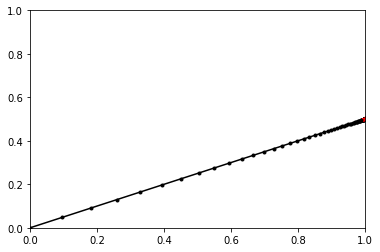

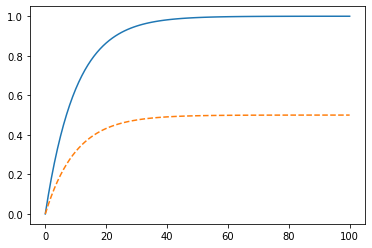

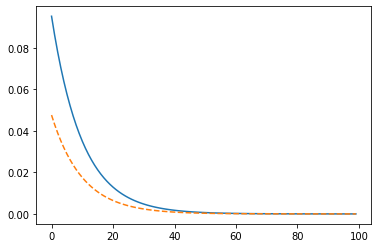

In [9]:
plt.plot(x[:, 0], x[:, 1], '-k.')
plt.plot(xstar[0], xstar[1], 'r*')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.figure()
plt.plot(x[:, 0])
plt.plot(x[:, 1], '--')

plt.figure()
plt.plot(u[:, 0])
plt.plot(u[:, 1], '--')

# OLD STUFF: iLQR

In [10]:
assert False, "Stop here"

AssertionError: Stop here

In [ ]:
# Specifies a general finite-horizon, time-varying control problem. Given cost
# function `c`, transition function `f`, and initial state `x0`, the goal is to
# compute:
#
#   argmin(lambda X, U: c(T, X[T]) + sum(c(t, X[t], U[t]) for t in range(T)))
#
# subject to the constraints that `X[0] == x0` and that:
#
#   all(X[t + 1] == f(X[t], U[t]) for t in range(T)) .
#
# The special case in which `c` is quadratic and `f` is linear is the
# linear-quadratic regulator (LQR) problem, and can be specified explicitly
# further below.
#
ControlSpec = collections.namedtuple(
    'ControlSpec', 'cost dynamics horizon state_dim control_dim')


In [ ]:
def make_lqr_approx(p):
  T = p.horizon

  def approx_timestep(t, x, u):
    M = jacfwd(grad(p.cost, argnums=2), argnums=1)(t, x, u).T
    Q = jacfwd(grad(p.cost, argnums=1), argnums=1)(t, x, u)
    R = jacfwd(grad(p.cost, argnums=2), argnums=2)(t, x, u)
    q, r = grad(p.cost, argnums=(1, 2))(t, x, u)
    A, B = jacobian(p.dynamics, argnums=(1, 2))(t, x, u)
    return Q, q, R, r, M, A, B

  _approx = vmap(approx_timestep)

  def approx(X, U):
    assert X.shape[0] == T + 1 and U.shape[0] == T
    U_pad = np.vstack((U, np.zeros((1,) + U.shape[1:])))
    Q, q, R, r, M, A, B = _approx(np.arange(T + 1), X, U_pad)
    return LqrSpec(Q, q, R[:T], r[:T], M[:T], A[:T], B[:T])

  return approx


def ilqr(iterations, p, x0, U):
  assert x0.ndim == 1 and x0.shape[0] == p.state_dim, x0.shape
  assert U.ndim > 0 and U.shape[0] == p.horizon, (U.shape, p.horizon)

  lqr_approx = make_lqr_approx(p)

  def loop(_, state):
    X, U = state
    p_lqr = lqr_approx(X, U)
    dX, dU = lqr_predict(p_lqr, np.zeros_like(x0))
    U = U + dU
    X = trajectory(p.dynamics, U, X[0] + dX[0])
    return X, U

  X = trajectory(p.dynamics, U, x0)
  return fori_loop(0, iterations, loop, (X, U))


# MPC

In [ ]:


def mpc_predict(solver, p, x0, U):
  assert x0.ndim == 1 and x0.shape[0] == p.state_dim
  T = p.horizon

  def zero_padded_controls_window(U, t):
    U_pad = np.vstack((U, np.zeros(U.shape)))
    return lax.dynamic_slice_in_dim(U_pad, t, T, axis=0)

  def loop(t, state):
    cost = lambda t_, x, u: p.cost(t + t_, x, u)
    dyns = lambda t_, x, u: p.dynamics(t + t_, x, u)

    X, U = state
    p_ = ControlSpec(cost, dyns, T, p.state_dim, p.control_dim)
    xt = X[t]
    U_rem = zero_padded_controls_window(U, t)
    _, U_ = solver(p_, xt, U_rem)
    ut = U_[0]
    x = p.dynamics(t, xt, ut)
    X = X.at[t + 1].set(x)
    U = U.at[t].set(ut)
    return X, U

  X = np.zeros((T + 1, p.state_dim))
  X = X.at[0].set(x0)
  return fori_loop(0, T, loop, (X, U))